In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import torch

In [ ]:
data = torch.zeros((3,4))
print(data.size())
output,_ = torch.max(data,1,keepdim = True)
print(output.size())

torch.Size([3, 4])
torch.Size([3, 1])


In [ ]:
from keras.datasets import mnist

In [ ]:
(x_train,t_target), (x_test,y_test) = mnist.load_data()
x_train = x_train.astype('float32')/255.0
x_test = x_train.astype('float32')/255.0
x_train = x_train.reshape(-1,784)
x_test = x_test.reshape(-1,784)

In [ ]:
def next_batch(input_data,target_data,batch_size):
    idx = np.arange(0,len(input_data))
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    input_shuffle = [input_data[i] for i in idx]
    target_shuffle = [target_data[i] for i in idx]
    return np.asarray(input_shuffle),np.asarray(target_shuffle)

In [ ]:
class VAE():
  
    def  __init__(self,input_dim,encode_dim,layer = 4):
        self.input_dim = input_dim
        self.encode_dim = encode_dim
        self.layer = 4
        self.initial_placeholder(input_dim)
        self.output,self.predict = self.build_model()
        self.loss,self.train_op = self.get_train_op(self.predict)
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
    def initial_placeholder(self,input_dim):
        self.Input_placeholder = tf.placeholder(tf.float32,shape = [None,input_dim])
        self.Output_placeholder = tf.placeholder(tf.float32,shape = [None,input_dim])
    def build_model(self):
        with tf.variable_scope('encoder',reuse=tf.AUTO_REUSE):
            w1 = tf.get_variable('w1',shape = (self.input_dim,256),initializer = tf.contrib.layers.xavier_initializer())
            b1 = tf.get_variable('b1',shape = (256,),initializer = tf.initializers.zeros())
            
            out1 = tf.nn.relu(tf.matmul(self.Input_placeholder,w1) + b1)
            
            w2 = tf.get_variable('w2',shape = (256,32),initializer = tf.contrib.layers.xavier_initializer())
            b2 = tf.get_variable('b2',shape = (32,),initializer = tf.initializers.zeros())
            
            #out2 = tf.nn.relu(tf.matmul(out1,w2) + b2)
            
            en_mean_w = tf.get_variable('en_mean_w',shape = (256,self.encode_dim),initializer = tf.contrib.layers.xavier_initializer())       
            en_mean_b = tf.get_variable('en_mean_b',shape = (self.encode_dim,),initializer = tf.initializers.zeros())
            self.en_mean = (tf.matmul(out1,en_mean_w) + en_mean_b)
            
            en_var_w = tf.get_variable('en_var_w',shape = (256,self.encode_dim),initializer = tf.contrib.layers.xavier_initializer())
            en_var_b = tf.get_variable('en_var_b',shape = (self.encode_dim,),initializer = tf.initializers.ones())
            self.en_var = (tf.matmul(out1,en_var_w) + en_var_b )
            
            epsilon = tf.random_normal(shape = (tf.shape(self.en_mean)[0],tf.shape(self.en_mean)[1]),mean = 0,stddev = 1)
            self.en_out = self.en_mean + tf.exp(self.en_var/2)* epsilon
            
        with tf.variable_scope('decoder',reuse=tf.AUTO_REUSE):
            de_w1 = tf.get_variable('w1',shape = (self.encode_dim,256),initializer = tf.random_normal_initializer(mean = 0,stddev = 1))
            de_b1 = tf.get_variable('b1',shape = (256,),initializer = tf.initializers.zeros())
            de_out1 = (tf.matmul(self.en_out,de_w1) + de_b1)
            
            #de_w2 = tf.get_variable('w2',shape = (32,512), initializer = tf.random_normal_initializer(mean = 0,stddev = 1))
            #de_b2 = tf.get_variable('b2',shape = (512,), initializer = tf.initializers.zeros())
            
            #de_out2 = (tf.matmul(de_out1,de_w2) + de_b2)
            
            de_w3 = tf.get_variable('w3',shape = (256,784),initializer = tf.random_normal_initializer(mean = 0,stddev = 1))
            de_b3 = tf.get_variable('b3',shape = (784,),initializer = tf.initializers.zeros())
            output = tf.matmul(de_out1,de_w3) + de_b3
            result = tf.sigmoid(output)
        return result,output
    def get_dict(self,_input,output = None):
        feed_dict = {}
        feed_dict[self.Input_placeholder] = _input
        if output is not None:
            feed_dict[self.Output_placeholder] = output
        return feed_dict
    def get_train_op(self,predict):
        loss = tf.reduce_sum(-0.5*(1 + self.en_var - tf.square(self.en_mean)- tf.exp(self.en_var)),axis = -1)
        loss = tf.reduce_mean(tf.transpose(784 * tf.nn.sigmoid_cross_entropy_with_logits(labels = self.Output_placeholder,logits = predict)) + loss)
        train_op = tf.train.AdamOptimizer(learning_rate = 0.01).minimize(loss)
        return loss,train_op
      
      
    def fit(self,input_data,target_data,batch_size,epoches):
        for epoch in range(epoches):
            for batch_time in range(int(len(input_data)/batch_size)):
                input_shuffle,target_shuffle = next_batch(input_data,target_data,batch_size)
                self.sess.run(self.train_op,feed_dict = self.get_dict(input_shuffle,target_shuffle))
                print("Loss ",self.sess.run(self.loss,feed_dict = self.get_dict(input_shuffle,target_shuffle)))
    
    
    def plot_result(self,mean,var):
        encode_feature = tf.random_normal(shape = (1,self.encode_dim),mean = mean,stddev = var)
        with tf.variable_scope('decoder',reuse=tf.AUTO_REUSE):
            de_w1 = tf.get_variable('w1',shape = (self.encode_dim,256),initializer = tf.random_normal_initializer(mean = 0,stddev = 1))
            de_b1 = tf.get_variable('b1',shape = (256,),initializer = tf.initializers.zeros())
            de_out1 = tf.nn.relu(tf.matmul(encode_feature,de_w1) + de_b1)
            
            de_w2 = tf.get_variable('w2',shape = (256,256), initializer = tf.random_normal_initializer(mean = 0,stddev = 1))
            de_b2 = tf.get_variable('b2',shape = (256,), initializer = tf.initializers.zeros())
            
            #de_out2 = tf.nn.relu(tf.matmul(de_out1,de_w2) + de_b2)
            
            de_w3 = tf.get_variable('w3',shape = (256,784),initializer = tf.random_normal_initializer(mean = 0,stddev = 1))
            de_b3 = tf.get_variable('b3',shape = (784,),initializer = tf.initializers.zeros())
            
            result = tf.sigmoid(tf.matmul(de_out1,de_w3) + de_b3)
        return result
    
    
    def plot_show(self,input_data):
        out = self.sess.run(self.output,feed_dict = self.get_dict(input_data))
        mean = self.sess.run(self.en_mean,self.get_dict(input_data))
        var = self.sess.run(self.en_var,self.get_dict(input_data))
        encode = self.sess.run(self.en_out,feed_dict = self.get_dict(input_data))
        for i in range(len(encode)):
            print(encode[i])
            print(mean[i])
            print(var[i])
            print('*'*10)
        out += 1.0
        out *=255.0
        out = np.asarray(out).reshape(-1,28,28)
        plt.figure()
        for i in range(3):
            for j in range(3):
                plt.subplot(3,3,(i)*3+j+1)
                plt.imshow(out[i*3+j])
        plt.show()

In [ ]:
vae = VAE(784,20)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [ ]:
vae.fit(x_train,x_train,batch_size = 2000,epoches = 200)

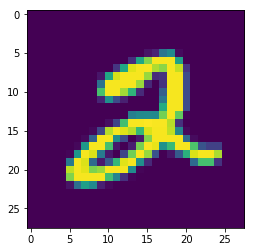

In [ ]:
plt.imshow(x_train[5].reshape(28,28))

In [ ]:
xvae.plot_show(x_train[:9])

In [ ]:
for i in range(9):
    plt.imshow((x_train[i]))
    plt.show()

In [ ]:
from keras.layers import Dense,Activation,Dropout,BatchNormalization,Input,Lambda
from keras.models import Sequential,Model
from keras import backend as K
from keras import losses as loss

In [ ]:
feature_dim = 784
latent_dim = 20
hidden_dim = 256
batch_size = 100
epoches = 50
def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epilson = K.random_normal(shape = (batch,dim),mean = 0,stddev = 1)
    return z_mean + K.exp(z_log_var / 2.0) * epilson

In [ ]:
encoder_input = Input(shape = (feature_dim,))

h1 = Dense(hidden_dim,activation = 'relu')(encoder_input)

z_mean = Dense(latent_dim)(h1)
z_log_var = Dense(latent_dim)(h1)

z = Lambda(sample,output_shape = (latent_dim,))([z_mean,z_log_var])

encoder = Model(encoder_input,[z_mean,z_log_var,z])

In [ ]:
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 256)          200960      input_7[0][0]                    
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 20)           5140        dense_16[0][0]                   
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 20)           5140        dense_16[0][0]                   
__________________________________________________________________________________________________
lambda_4 (

In [ ]:
decoder_input = Input(shape = (latent_dim,))
de_h1 = Dense(hidden_dim,activation = 'relu')(decoder_input)
out = Dense(feature_dim,activation = 'sigmoid')(de_h1)
decoder = Model(decoder_input,out)
decoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 20)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               5376      
_________________________________________________________________
dense_20 (Dense)             (None, 784)               201488    
Total params: 206,864
Trainable params: 206,864
Non-trainable params: 0
_________________________________________________________________


In [ ]:
decoder_output = decoder(encoder(encoder_input)[2])
vae = Model(encoder_input,decoder_output)
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 784)               0         
_________________________________________________________________
model_8 (Model)              [(None, 20), (None, 20),  211240    
_________________________________________________________________
model_9 (Model)              (None, 784)               206864    
Total params: 418,104
Trainable params: 418,104
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def vae_loss(y_true, y_pred):
    xent_loss = feature_dim * loss.binary_crossentropy(K.flatten(y_true), K.flatten(y_pred))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    loss_ = K.mean(xent_loss + kl_loss)
    return loss_

In [ ]:
#vae.add_loss(kl_loss)
vae.compile(loss = vae_loss,optimizer = 'adam')

In [ ]:
print(x_train[0][300:320])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.54509807]


In [ ]:
print(x_train.shape)

(60000, 784)


In [ ]:
vae.fit(x_train,x_train,epochs = 5,batch_size = 100)

Epoch 1/5
60000/60000 [==============================] - 6s 100us/step - loss: 164.8157
Epoch 2/5
60000/60000 [==============================] - 6s 94us/step - loss: 124.2365
Epoch 3/5
60000/60000 [==============================] - 6s 92us/step - loss: 116.9278
Epoch 4/5
60000/60000 [==============================] - 6s 92us/step - loss: 113.5618
Epoch 5/5
60000/60000 [==============================] - 6s 93us/step - loss: 111.5664


In [ ]:
sample = np.random.normal(0,3,(9,20))

In [ ]:
out = decoder.predict(sample)
out = out.reshape(-1,28,28)

In [ ]:
print(np.asarray([x_train[0]]).shape)

(1, 784)


In [ ]:
print(np.mean(encoder.predict([[x_train[0]]])))
print(np.mean(encoder.predict([[x_train[1]]])))

-1.0884745
-0.5461601


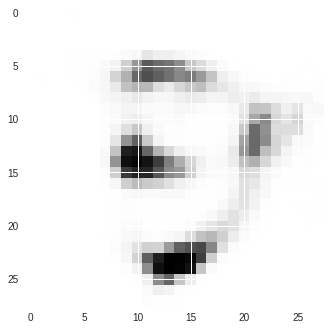

In [ ]:
plt.imshow(out[1])

In [ ]:
p = out[1]
p = p.reshape(28,28)

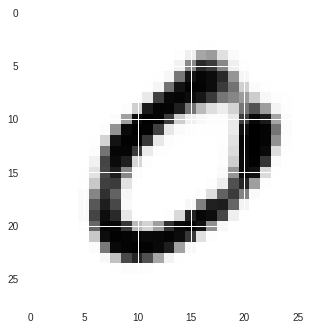

In [ ]:
plt.imshow(p)

In [ ]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
nb_epoch = 50
epsilon_std = 1.0

x = Input(batch_shape=(batch_size, original_dim))#1
h = Dense(intermediate_dim, activation='relu')(x)#2
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [ ]:
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [ ]:
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [ ]:
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * loss.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

In [ ]:
vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=nb_epoch,
        batch_size=batch_size,
validation_data=(x_test, x_test))